In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

(uncertainty-propagation)=
# The Uncertainty Propagation Problem

The uncertainty propagation problem is as follows.
You have a causal model that relates some input variables to some output variables.
You are uncertain about the input variables.
You want to predict the output variables and quantify the uncertainty in the predictions.

## Example: Driving a trailer on a rough road

I have modified the following examples from Purdue's Basic Mechanics II Lecture Book.
In the figure, you see a trailer of mass m moving on a rough road with speed $v$.
The suspension spring constant is $k$.
We are interested in the vibration amplitude $X$.

![Trailer](../images/trailer.png)

Let us assume the road surface is sinusoidal with amplitude $y_0$ and "wavelength" $L$.
Doing a [little bit of dynamics](https://www.youtube.com/watch?v=d4OKBqr_aYQ&feature=youtu.be) shows that the amplitude of the suspension oscillation is:

$$
X = \left|\frac{ky_0}{k-m\omega^2}\right|,
$$

where the angular velocity is:

$$
\omega = \frac{2\pi v}{L}.
$$

Let's draw the causal graph:

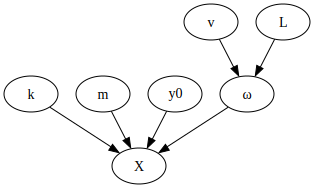

In [7]:
from graphviz import Digraph
g = Digraph('Trailer')
g.node('k')
g.node('m')
g.node('y0', label='<y<sub>0</sub>>')
g.node('omega', label='<&omega;>')
g.node('v')
g.node('L')
g.node('X')
g.edge('v', 'omega')
g.edge('L', 'omega')
g.edge('y0', 'X')
g.edge('omega', 'X')
g.edge('k', 'X')
g.edge('m', 'X')
#g.render('trailer_g', format='png')
g

### Questions

+ Which of the variables $v$, $L$, $k$, $m$, $y_0$ are aleatory and which epistemic?
```{admonition} Answer
:class: dropdown
There are many correct answers to this question.
It depends on the context.
For example, if you are driving a specific trailer, you may not know what $k$ and $m$ are.
Then, you would consider them epistemic.
However, if you consider the process that manufactured the trailer, then $k$ and $m$ could be aleatory.
```

+ Pick one of the epistemic variables and explain how you would reduce its uncertainty.
```{admonition} Answer
:class: dropdown
If we pick the trailer's mass, we could reduce its uncertainty by weighing it.
```

+ The variables we have included in the model are the ones we know are important. We may be uncertain about them, but they are "known unknowns." There are other variables that we may not even know are important. These are "unknown unknowns." Think hard and come up with at least one "unknown unknown." By doing so, you are effectively turning it into a known unknown.
```{admonition} Answer
:class: dropdown
The air pressure in the tires is an unknown unknown.
```

## Solving uncertainty propagation problems

As mentioned, we describe both aleatory and epistemic uncertainties using probability theory.
So, one of the first steps of predictive modeling is to develop probability statements for all uncertain variables.
However, this is also one of the most challenging problems.
So, let us assume that someone has already done it for us.
The next step is to propagate this uncertainty through the causal model to characterize our uncertainty about a quantity of interest.
Let us demonstrate both steps using the trailer example.

The simplest way to solve the uncertainty propagation problem is via sampling.
The approach is known as the *Monte Carlo* method.
We will study the Monte Carlo method extensively.
For now, let's look at a simple example.

### Example: Driving a trailer on a rough road (continued)

To make this more precise, assume that we are the trailer manufacturer.
Let's quantify our state of knowledge about this model's parameters using a bit of common sense.

| Variable | Type | Values| 
|:---------|:--------------|:--------|
| $k$ | Manufacturing uncertainty | [159,999, 160,001] N/m |
| $v$ | Operating condition | [80, 150] km/hour |
| $m$ | Loading condition | [100, 200] kg|
| $y_0$ | Road condition | [0, 100] mm|
| $L$ | Road condition | [1, 2] m |

Not being able to come up with more precise information (or any data), we consider any value within these intervals equally likely.

Let's write some code to see how this uncertainty affects the angular velocity $\omega$ and the amplitude $X$.
The code does the following:
+ It samples 1000 values for each variable.
+ It computes the angular velocity $\omega$ and the amplitude $X$ for each sample.
+ It plots the histograms of $\omega$ and $X$.

In [8]:
# We need to import numpy to use the random number generator
import numpy as np

# The number of samples we wish to take
num_samples = 1000

# Two arrays in which to store the samples we take
Xs = np.ndarray((num_samples, ))
omegas = np.ndarray((num_samples, ))

for i in range(num_samples):
    # Sample all the parameters from their distributions
    k = 160000.0 + np.random.rand()
    m = 100.0 + (200.0 - 100.0) * np.random.rand()
    y0 = 100 * np.random.rand() * 1e-3
    v = (80.0 + (150.0 - 80.0) * np.random.rand()) * 1e3 / 3600.0
    L = 1.0 + (2.0 - 1.0) * np.random.rand()
    
    # Calculate the angular velocity
    omega = 2.0 * np.pi * v / L
    # Calculate the amplitude
    X = np.abs(k * y0 / (k - m * omega ** 2))

    # Store the samples
    omegas[i] = omega
    Xs[i] = X

Plot the normalized histogram of the angular velocity:

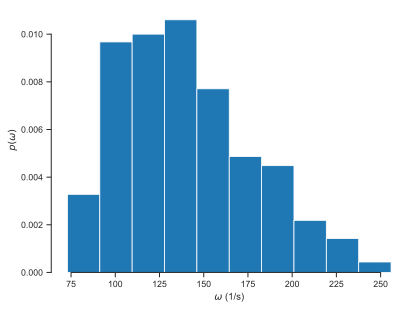

In [9]:
fig, ax = plt.subplots()
ax.hist(omegas, density=True)
ax.set_xlabel(r"$\omega$ (1/s)")
ax.set_ylabel(r"$p(\omega)$")
sns.despine(trim=True);

And here is the histogram of the amplitude:

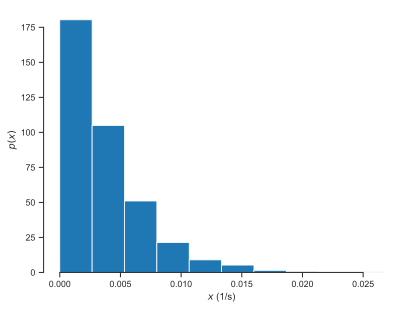

In [10]:
fig, ax = plt.subplots()
ax.hist(Xs, density=True)
ax.set_xlabel(r"$x$ (1/s)")
ax.set_ylabel(r"$p(x)$")
sns.despine(trim=True);

### Questions
+ What does the probability density in the figures above represent? Is the uncertainty aleatory or epistemic?
```{admonition} Answer
:class: dropdown
The probability density represents our state of knowledge about the angular velocity and the amplitude.
Whether or not it is aleatory or epistemic depends on the context.
```

+ Rerun the code above giving different values to ``num_samples``. Can you trust the results when you pick small values? Do the results "converge" to something as you increase the number of samples?
```{admonition} Answer
:class: dropdown
For small values of ``num_samples``, the results are not reliable.
For large values, the results seem to converge to a specific density.
This is a consequence of the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers).
We will learn about it later in the course.
```